In [7]:
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner

# platform = "jupyter"
# params.confirm_cwd(platform)
model_params = params.model_params

colors = {
    'light_blue': '#a3d5e4',
    'blue': '#41678d',
    'purple': '#7b6785',
    'red': '#d18375',
    'peach': '#efb68d',
    'grey':'#D3D3D3',
    'orange':'#ff7f0e',
    'white':'#FFFFFF'}


In [2]:
def select_value(row):
    columns = row.index.tolist()
    if ('death_year' not in columns) or (pd.isnull(row['death_year'])):
        
        if ('deathY' not in columns) or (pd.isnull(row['deathY'])) :
                
            if ('radyear' not in columns) or (pd.isnull(row['radyear']) ):
                if row['death']==1:
                    val = 'Error'
                else:
                    val=None
            else:
                val = row['radyear']
        else:
            val = row['deathY']
    else:
        val = row['death_year']
    
    return val

datasets = {'HRS':'death_year','SHARE':'deathY','ELSA':'radyear','COMB':'death_year'}


# Death by gender and survey

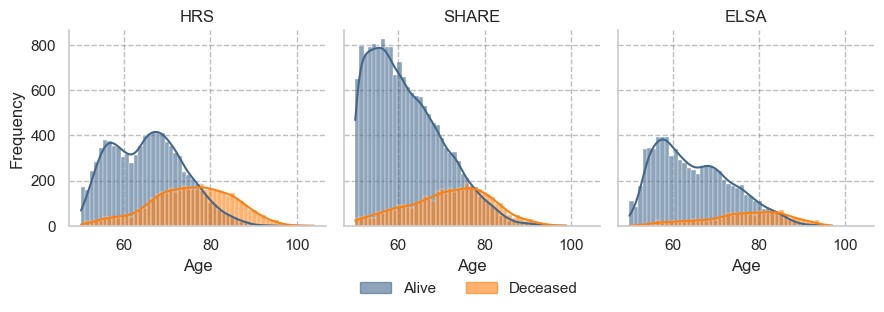

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharey=True, sharex=True)
axs = ax.flatten()

for i, dataset in enumerate(['HRS', 'SHARE', 'ELSA']):
    # Load dataset
    df = params.data_reader(dataset=dataset, source='us', bio=False)

    # Plot stacked histogram
    sns.histplot(
        data=df,
        x='age',
        hue='death',
        hue_order=[1, 0],  # Ensure that the colors are consistent
        ax=axs[i],
        #multiple='stack',  # Stacked histogram
        kde=True,
        alpha=0.6,
        palette={0: colors['blue'], 1: colors['orange']},
        bins=df['age'].nunique()+1 if dataset=='HRS' else df['age'].nunique()

    )

    # Formatting
    axs[i].set_title(f'{dataset}')
    axs[i].set_xlabel('Age')
    axs[i].set_ylabel('Frequency')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].grid(axis='y', color='gray', linestyle='--', linewidth=1, alpha=0.5)
    axs[i].grid(axis='x', color='gray', linestyle='--', linewidth=1, alpha=0.5)
    axs[i].get_legend().remove()
alive_patch = mpatches.Patch(color=colors['blue'], label='Alive', alpha=0.6)
deceased_patch = mpatches.Patch(color=colors['orange'], label='Deceased', alpha=0.6)

# Create a single legend at the bottom
fig.legend(
    handles=[alive_patch, deceased_patch],
    loc='lower center',
    ncol=2,  # Arrange legend items horizontally
    bbox_to_anchor=(0.53, -0.06),  # Position at the bottom of the figure
    frameon=False
)

# Add a super title for all subplots
#fig.suptitle('Age Distribution by Death Status', fontsize=14)

#plt.subplots_adjust(bottom=0.1)
fig.tight_layout()# Adjust layout to make room for legend
plt.savefig('graphs/data_description/age_distribution_with_death.pdf')

# Risk Facotr inclusion/exclusion

In [3]:
df_all_variables = pd.DataFrame()
df_all_variables['variables'] = list(set([x for domain in params.domain_dict.keys() if domain not in ['bio','bio_adjusted','all_bio','all_bio_adjusted'] for x in params.domain_dict[domain]]))

# mark variables from each dataset 
for dataset in ['HRS','SHARE','ELSA']:
    df_all_variables[dataset] = None
    df = params.data_reader(dataset=dataset,source='us',bio=False)
    for var in params.domain_dict['all']:
        if var in df.columns:
            df_all_variables.loc[df_all_variables['variables']==var,dataset] = 1
            
# Add domain column
df_all_variables['domain'] = df_all_variables['variables']
for domain in ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']:
    domain_vars = params.domain_dict[domain]
    if domain != 'demographic':
        domain_vars = list(set(domain_vars)-set(params.domain_dict['demographic']))
    df_all_variables.loc[df_all_variables['variables'].isin(domain_vars),'domain']= domain
    
# Sort the dataframe by domain 
df_all_variables.sort_values('domain', inplace=True)
df_all_variables.reset_index(drop=True,inplace=True)
df_all_variables.fillna(0,inplace=True)


In [5]:
# Replace variables with readable names
heatmap_data = df_all_variables.set_index('variables')[['HRS', 'SHARE', 'ELSA']]
df_means = pd.DataFrame(heatmap_data).copy()
for dataset in ['HRS', 'SHARE', 'ELSA']:
    
    if dataset =='SHARE':
        df = pd.read_pickle("/Users/valler/Python/OX_Thesis/OX_thesis/data/SHARE/recoded_data_wave_1.pkl")
        df_SHARE = params.data_reader(dataset='SHARE', source='us', bio=False)
        df = df.loc[df['mergeid'].isin(df_SHARE['mergeid']),]
        
    elif dataset == 'ELSA':
        
        df = pd.read_csv('/Users/valler/Python/OX_Thesis/OX_thesis/Data/ELSA/recoded_data_w2.csv')
        df.drop(columns=['Zfatherseduc','Zmotherseduc','sleepYN'],inplace=True)
        df_elsa = params.data_reader(dataset='ELSA', source='us', bio=False)
        df = df.loc[df['idauniq'].isin(df_elsa['idauniq']),]
        
        df['age']=[2005-x for x in df['rabyear']]
        df.rename(columns={'male':'maleYN'},inplace=True)
        
    elif dataset == 'HRS':
        df = pd.read_pickle('/Users/valler/Python/OX_Thesis/OX_thesis/data/HRS/data_preprocess/Data/merge_data_not_standardise.pkl')
        df_HRS = params.data_reader(dataset='HRS', source='us', bio=False)
        df_HRS['hhidpn'] =  ["{:06d}".format(int(x)) + '{:03d}'.format(int(y)) for x, y in zip(df_HRS['hhid'], df_HRS['pn'])]
        df['hhidpn'] =  ["{:06d}".format(int(x)) + '{:03d}'.format(int(y)) for x, y in zip(df['hhid'], df['pn'])]
        df = df.loc[df['hhidpn'].isin(df_HRS['hhidpn']),]

    for var in df_means.index:
        if var in df.columns:
            if df[var].nunique()==2:
               df[var] = df[var].replace(-1,0)
            df[var] = df[var].astype(float)
            df_means.loc[var, dataset] = f'{df[var].mean():.2f}({df[var].std():.2f})'
        else:
            df_means.loc[var, dataset] = '-'

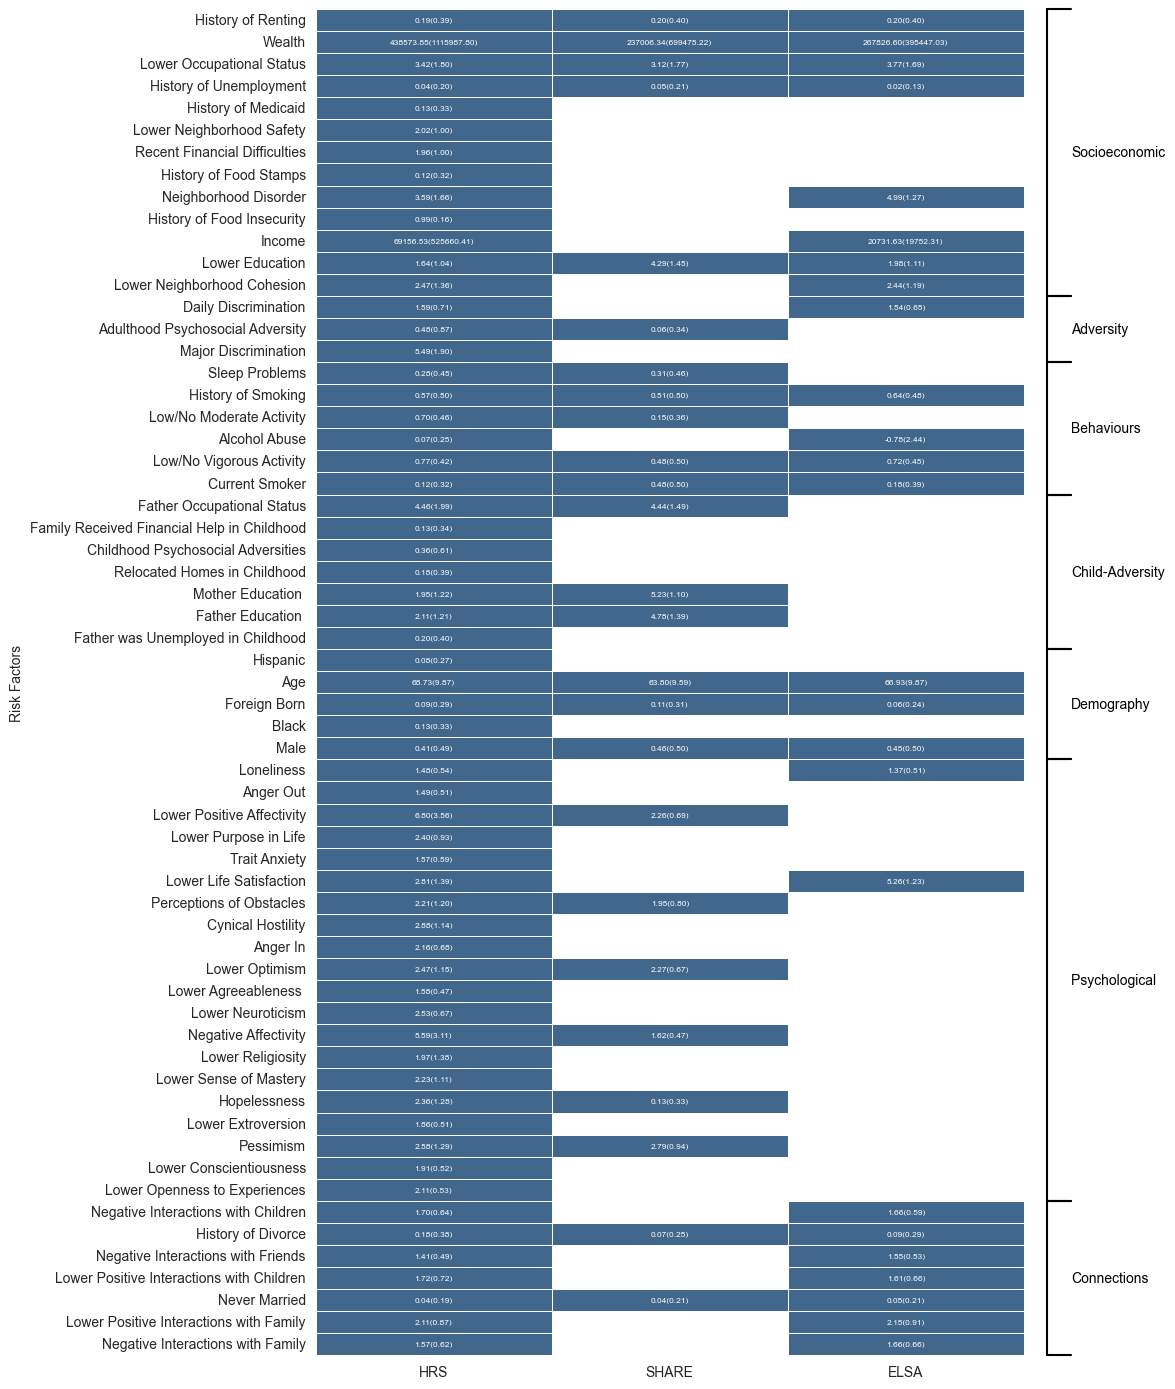

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological ',
                      'bio_adjusted':'Biomarkers',
                       'pr_f1_contribution':'F1 Score',
                       'pr_auc_contribution':'PR-AUC Score',
                      'roc_auc_contribution':'ROC-AUC Score',
                      'imv_contribution':'IMV'}

# Replace variables with readable names
heatmap_data = df_all_variables.set_index('variables')[['HRS', 'SHARE', 'ELSA']]


heatmap_data.index = heatmap_data.index.map(lambda x: params.var_dict.get(x, x))  # Replace with readable names

# Custom colormap
custom_cmap = ListedColormap([colors['white'], colors['blue']])

# Plot heatmap
plt.figure(figsize=(12, 14))
ax = sns.heatmap(
    heatmap_data,
    annot = df_means,
    fmt="", 
    annot_kws={"size": 6, "color": "white", "ha": "center"},
    cmap=custom_cmap,  # Color scheme
    linewidths=0.5,
    cbar=False,  # Remove the color bar
)

# Adjust y-axis label size
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)  # Adjust font size for y-axis labels

# Add brackets and one label per domain
domain_groups = df_all_variables.groupby('domain')
for domain, group in domain_groups:
    start_idx = group.index[0]  # Start index of the domain
    end_idx = group.index[-1]  # End index of the domain
    
    # Add text for the domain
    ax.text(
        heatmap_data.shape[1] + 0.2,  # Position on the right of the plot
        (start_idx + end_idx + 1) / 2,  # Midpoint of the domain rows
        f'{replace_name_dict[domain]}',  # Text for the domain
        va='center', ha='left', fontsize=10, color='black'
    )
    
    # Add brackets for the domain
    ax.plot(
        [heatmap_data.shape[1] + 0.1] * 2,  # Vertical line position (right of the plot)
        [start_idx, end_idx + 1],  # Span of the domain
        color='black', linewidth=1.5, clip_on=False
    )
    ax.plot(
        [heatmap_data.shape[1] + 0.1, heatmap_data.shape[1] + 0.2],  # Horizontal line (top)
        [start_idx, start_idx],  # Top of the bracket
        color='black', linewidth=1.5, clip_on=False
    )
    ax.plot(
        [heatmap_data.shape[1] + 0.1, heatmap_data.shape[1] + 0.2],  # Horizontal line (bottom)
        [end_idx + 1, end_idx + 1],  # Bottom of the bracket
        color='black', linewidth=1.5, clip_on=False
    )

# Add labels and title
#plt.title('Variable Availability in Datasets', fontsize=12)
# plt.xlabel('Datasets')
plt.ylabel('Risk Factors')

# Add a legend below the plot
legend_labels = [
    
    mpatches.Patch(color=colors['blue'], label='Available'),
    mpatches.Patch(color=colors['grey'], label='Not Available')
]
'''plt.legend(
    handles=legend_labels,
    loc='lower center',
    bbox_to_anchor=(1.4, -0.01),
    ncol=1,
    frameon=False,
    fontsize=9
)'''

# Adjust layout
plt.tight_layout()
# Show plot
plt.savefig('graphs/data_description/variable_availability_with_datainfo.pdf')
